# Backup V8

Running initial simulation...


2024-07-11 15:49:00,595 - INFO - After MOT: N = 2.70e+05, mean T = 27.95 μK
2024-07-11 15:49:00,690 - WARNING - Sudden change detected at t = 0.099s: ΔN/N = -0.01, ΔT/T = 3.44
2024-07-11 15:49:01,670 - INFO - At t = 0.100s: N = 2.50e+05, mean T = 137.37 μK
2024-07-11 15:50:08,249 - INFO - At t = 0.200s: N = 2.48e+05, mean T = 4518.04 μK
2024-07-11 15:51:09,163 - INFO - At t = 0.300s: N = 2.47e+05, mean T = 15012.98 μK
2024-07-11 15:52:02,940 - INFO - At t = 0.400s: N = 2.46e+05, mean T = 31634.48 μK
2024-07-11 15:52:20,683 - INFO - At t = 0.500s: N = 2.46e+05, mean T = 54384.73 μK
2024-07-11 15:52:31,776 - INFO - Final simulation results: shape = (7,)
2024-07-11 15:52:31,777 - INFO - Final trap frequencies: shape = (7, 3)


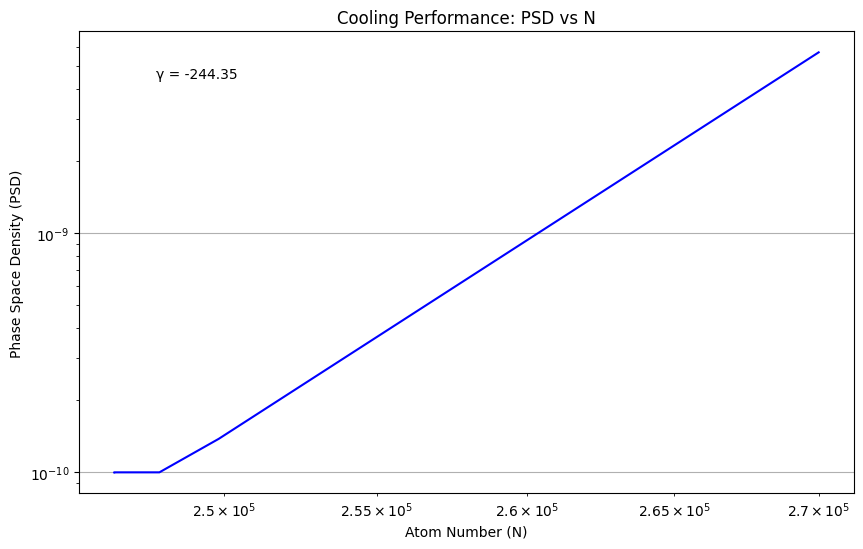

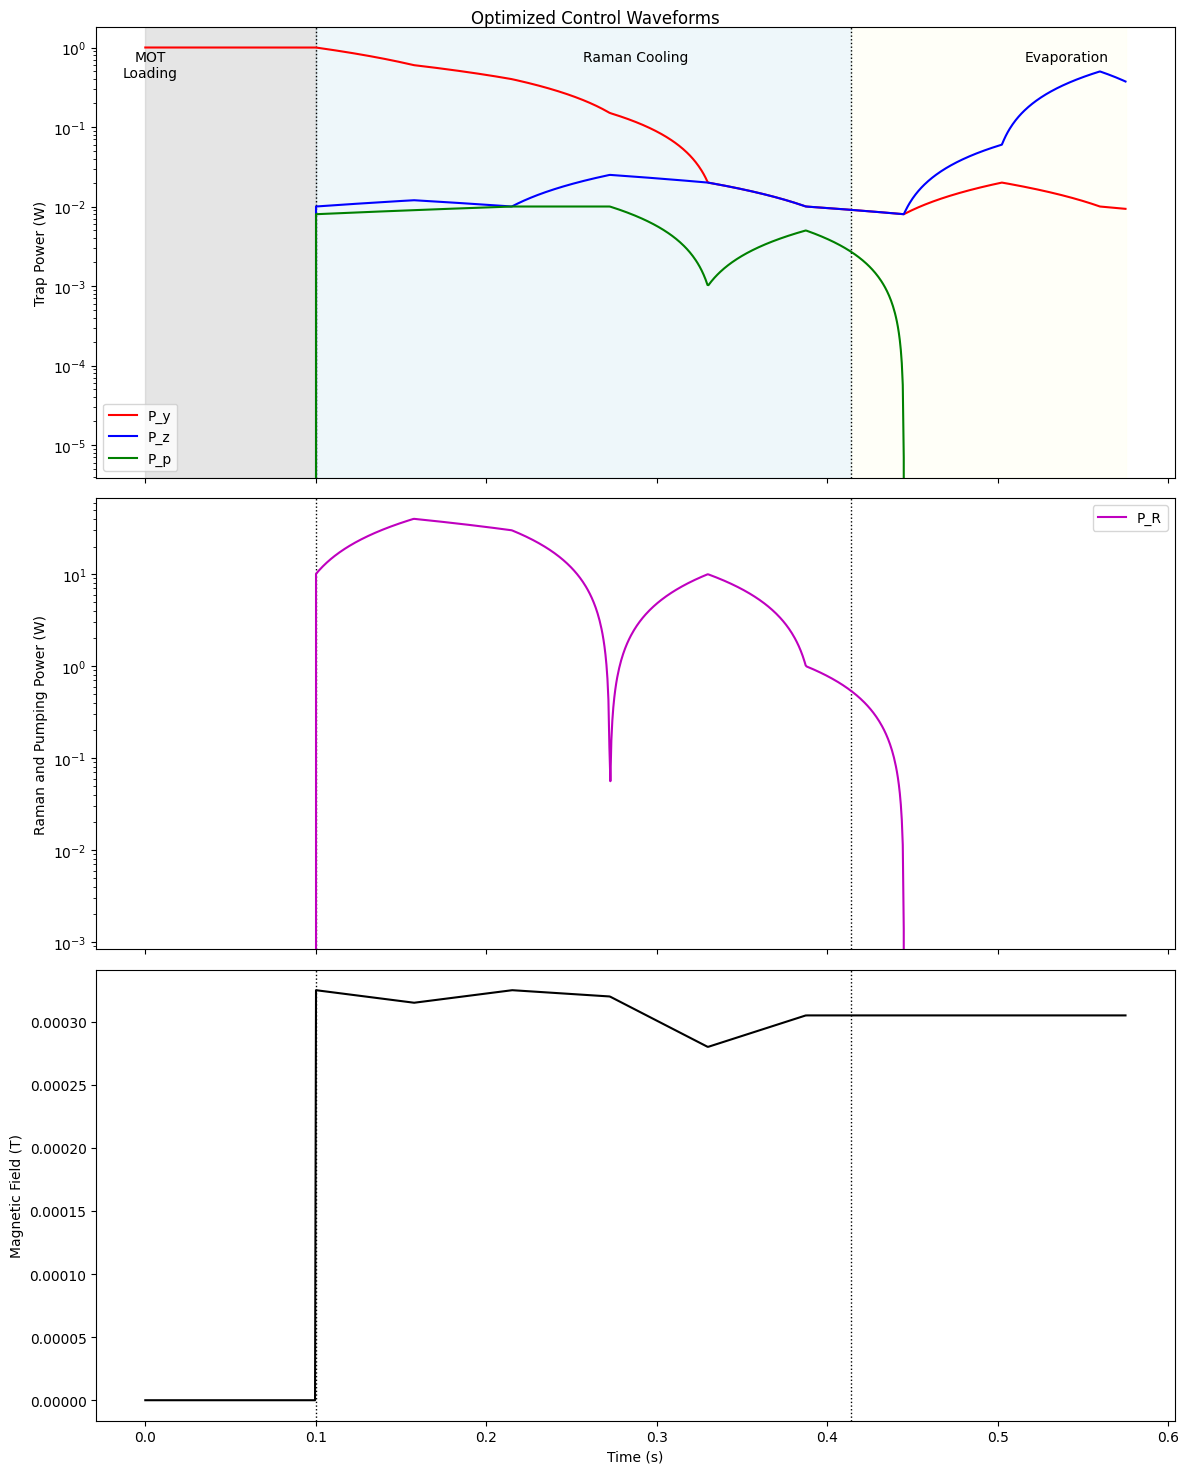

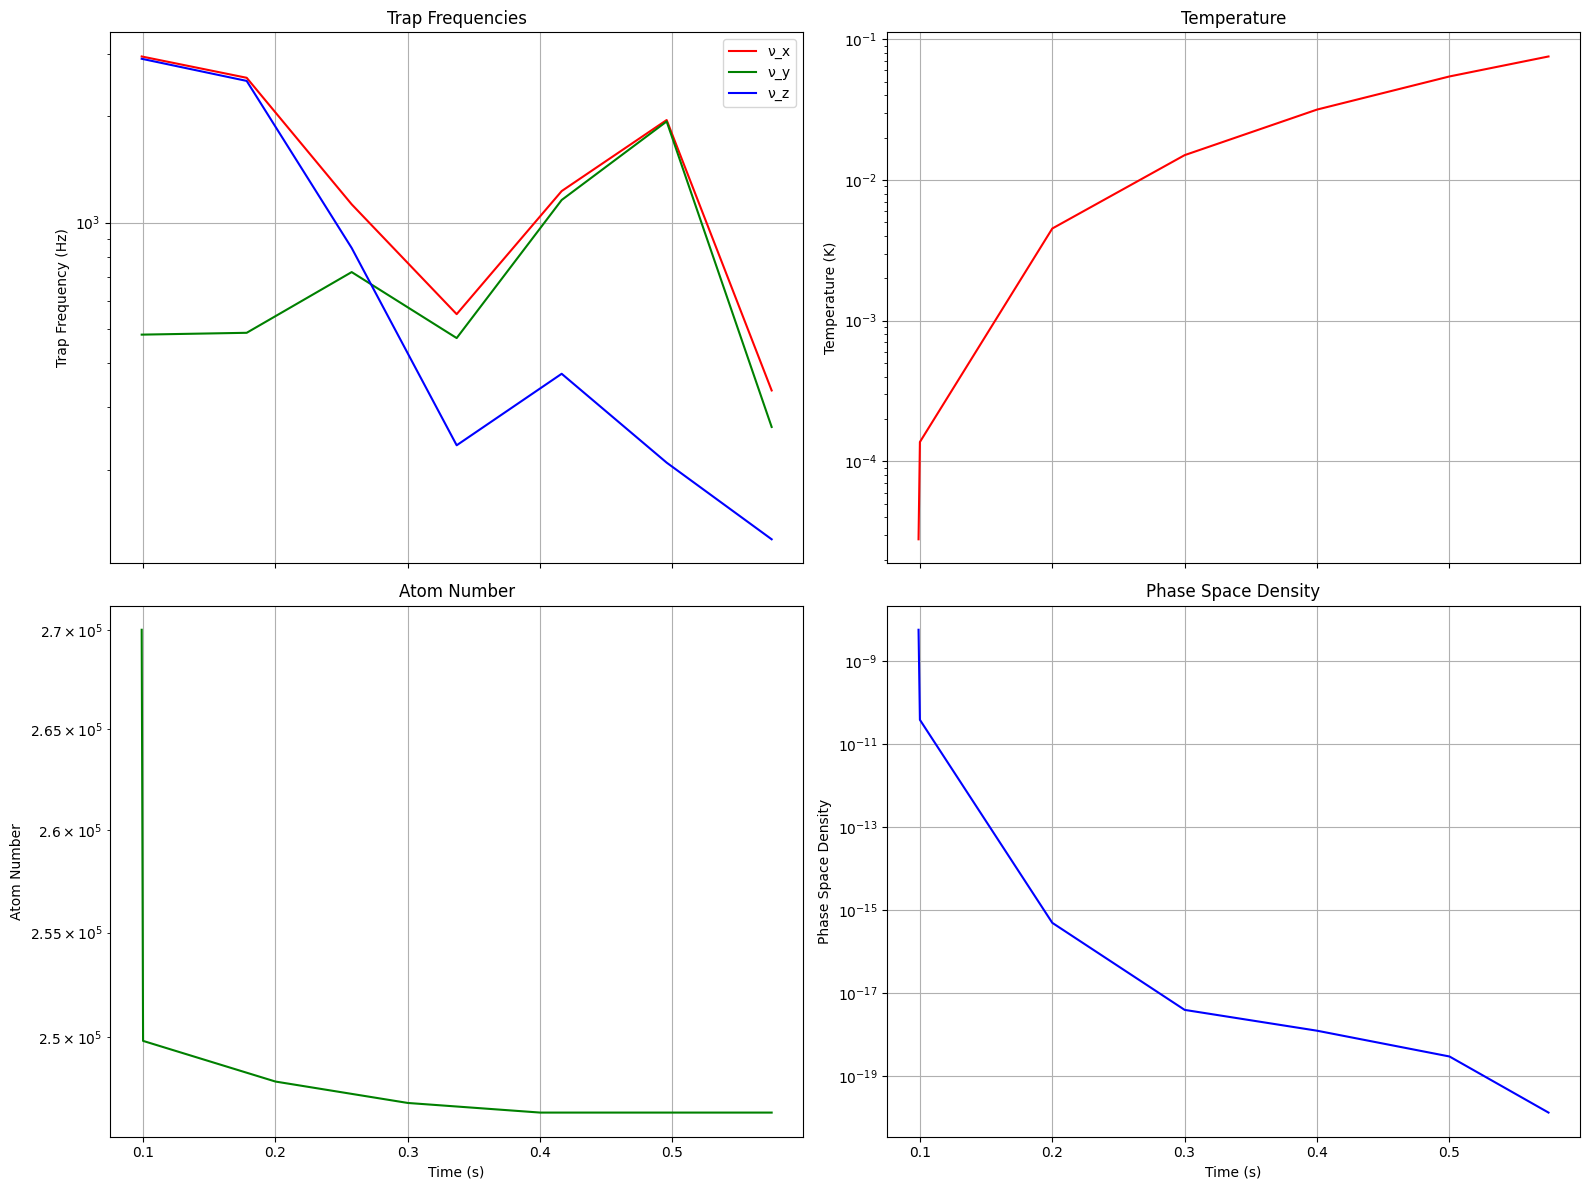

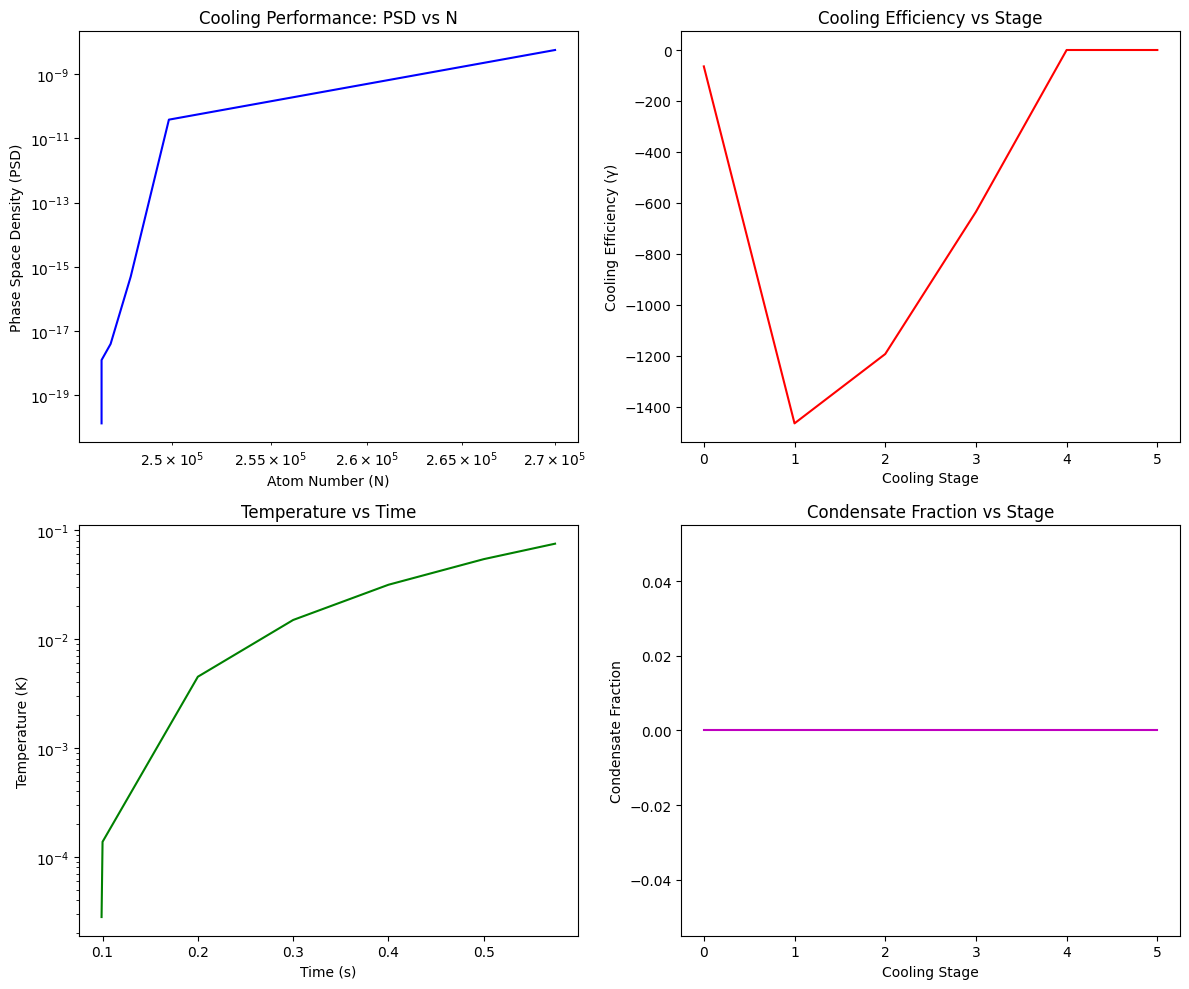

Final Temperature: 75408.62 μK
Final Atom Number: 2.46e+05
Final PSD: 1.35e-20
Estimated Condensate Fraction: 0.0%
Starting optimization process...


2024-07-11 15:52:52,237 - INFO - After MOT: N = 2.70e+05, mean T = 27.98 μK
2024-07-11 15:52:52,382 - WARNING - Sudden change detected at t = 0.099s: ΔN/N = -0.34, ΔT/T = 2.96
2024-07-11 15:52:52,450 - WARNING - Sudden change detected at t = 0.099s: ΔN/N = -0.33, ΔT/T = 0.01
2024-07-11 15:52:52,494 - WARNING - Sudden change detected at t = 0.099s: ΔN/N = -0.33, ΔT/T = 0.01
2024-07-11 15:52:52,528 - WARNING - Sudden change detected at t = 0.099s: ΔN/N = -0.32, ΔT/T = 0.01
2024-07-11 15:52:52,551 - WARNING - Sudden change detected at t = 0.099s: ΔN/N = -0.32, ΔT/T = 0.01
2024-07-11 15:52:52,569 - WARNING - Sudden change detected at t = 0.100s: ΔN/N = -0.31, ΔT/T = 0.01
2024-07-11 15:52:52,583 - WARNING - Sudden change detected at t = 0.100s: ΔN/N = -0.30, ΔT/T = 0.01
2024-07-11 15:52:52,592 - WARNING - Sudden change detected at t = 0.100s: ΔN/N = -0.30, ΔT/T = 0.01
2024-07-11 15:52:52,600 - WARNING - Sudden change detected at t = 0.100s: ΔN/N = -0.29, ΔT/T = 0.01
2024-07-11 15:52:52,612 

KeyboardInterrupt: 

In [2]:
import numpy as np
from scipy.constants import h, hbar, k, atomic_mass, mu_0, g, c, epsilon_0
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit, minimize_scalar
from scipy.interpolate import interp1d
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Rubidium-87 properties
class Rb87:
    mass = 86.909180527 * atomic_mass
    wavelength_D1 = 794.979e-9  # meters
    wavelength_D2 = 780.241e-9  # meters
    gamma_D1 = 2 * np.pi * 5.746e6  # rad/s
    gamma_D2 = 2 * np.pi * 6.065e6  # rad/s
    a_s = 98 * 5.29e-11  # s-wave scattering length in meters
    g_F = 1/2  # Landé g-factor for F=2 state
    mu_B = 9.274e-24  # Bohr magneton in J/T
    
    # Calculate recoil energy for D1 transition
    Er_D1 = (h / wavelength_D1)**2 / (2 * mass)  # Joules
    
    # Calculate recoil velocity for D1 transition
    vr_D1 = h / (mass * wavelength_D1)  # m/s

    @classmethod
    def calculate_trap_frequency(cls, P, w0, wavelength):
        # Calculate trap frequency for a given beam power, waist, and wavelength
        U0 = 2 * cls.calculate_polarizability(wavelength) * P / (np.pi * c * epsilon_0 * w0**2)
        return np.sqrt(4 * U0 / (cls.mass * w0**2))

    @classmethod
    def calculate_polarizability(cls, wavelength):
        # This is a simplified calculation and might need to be adjusted for accuracy
        return 5.3e-39  # m^3, approximate value for 1064 nm
    
    @classmethod
    def calculate_K3(cls, T):
        K3_0 = 4.3e-29  # cm^6/s for Rb-87 in |2, -2⟩ state
        T_scale = 100e-6  # 100 μK
        return K3_0 * (1 + (T / T_scale)**2) * 1e-12  # Convert to m^6/s


# Simulation parameters
N_atoms_initial = int(2.7e5)
T_initial = 300e-6
dt = 1e-4

class DipleTrap:
    def __init__(self, P_y, P_z, w_y, w_z, wavelength):
        self.P_y = P_y
        self.P_z = P_z
        self.w_y = w_y
        self.w_z = w_z
        self.wavelength = wavelength
        self.k = 2 * np.pi / wavelength
        self.alpha = Rb87.calculate_polarizability(wavelength)
        self.update_trap_frequencies()

    def update_trap_frequencies(self):
        U0_y = 2 * self.alpha * self.P_y / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = 2 * self.alpha * self.P_z / (np.pi * c * epsilon_0 * self.w_z**2)
        self.omega_x = np.sqrt(4 * U0_y / (Rb87.mass * self.w_y**2) + 4 * U0_z / (Rb87.mass * self.w_z**2))
        self.omega_y = np.sqrt(4 * U0_z / (Rb87.mass * self.w_z**2))
        omega_z_squared = 4 * U0_y / (Rb87.mass * self.w_y**2) - 2 * g / self.w_y
        self.omega_z = np.sqrt(max(0, omega_z_squared))  # Ensure non-negative value
        
        logging.debug(f"Updated trap frequencies: omega_x = {self.omega_x:.2e}, "
                      f"omega_y = {self.omega_y:.2e}, omega_z = {self.omega_z:.2e}")

    def potential(self, x, y, z):
        U_y = -2 * self.alpha * self.P_y * np.exp(-2 * ((x**2 + z**2) / self.w_y**2)) / (np.pi * self.w_y**2 * c * epsilon_0)
        U_z = -2 * self.alpha * self.P_z * np.exp(-2 * ((x**2 + y**2) / self.w_z**2)) / (np.pi * self.w_z**2 * c * epsilon_0)
        U_gravity = Rb87.mass * g * z
        return U_y + U_z + U_gravity


    def force(self, x, y, z):
        F_x = -4 * self.alpha * self.P_y * x * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) \
              -4 * self.alpha * self.P_z * x * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_y = -4 * self.alpha * self.P_z * y * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_z = -4 * self.alpha * self.P_y * z * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) - Rb87.mass * g
        return np.column_stack((F_x, F_y, F_z))

    def calculate_tilt(self):
        denominator = self.omega_y**2 * self.w_y
        if denominator == 0:
            logging.warning("Division by zero encountered in calculate_tilt. Returning 0.")
            return 0
        tilt = np.arctan(g / denominator)
        logging.debug(f"Calculated tilt: {tilt:.2e}")
        return tilt

class LaserBeam:
    def __init__(self, power, w_x, w_y, wavelength, direction=[0, 0, 1]):
        self.power = power
        self.w_x = w_x
        self.w_y = w_y
        self.wavelength = wavelength
        self.k = 2 * np.pi / wavelength * np.array(direction) / np.linalg.norm(direction)

    def intensity(self, positions):
        x, y, _ = positions.T
        return 2 * self.power / (np.pi * self.w_x * self.w_y) * np.exp(-2 * (x**2 / self.w_x**2 + y**2 / self.w_y**2))
    

class AtomCloud:
    def __init__(self, N, T, trap):
        self.N = int(max(N, 1))  # Ensure at least one atom
        self.T = np.full(self.N, max(T, 1e-9))  # Ensure non-zero temperature (1 nK minimum)
        self.trap = trap
        self.positions = self.initialize_positions()
        self.velocities = self.initialize_velocities()
        self.light_shift = 0

    def initialize_positions(self):
        sigma = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (2*np.pi*100)**2))
        return np.random.normal(0, sigma, (self.N, 3))

    def initialize_velocities(self):
        sigma_v = np.sqrt(k * self.T[:, np.newaxis] / Rb87.mass)
        return np.random.normal(0, sigma_v, (self.N, 3))
    
    def force_sync(self):
        self.N = int(self.N)
        self.N = min(self.N, len(self.positions), len(self.velocities), len(self.T))
        self.positions = self.positions[:self.N]
        self.velocities = self.velocities[:self.N]
        self.T = self.T[:self.N]
        logging.debug(f"After force_sync: N = {self.N}, "
                      f"positions shape = {self.positions.shape}, "
                      f"velocities shape = {self.velocities.shape}, "
                      f"T shape = {self.T.shape}")

    def update(self, dt):
        forces = self.trap.calculate_force(self.positions)
        self.velocities += forces * dt / Rb87.mass
        self.positions += self.velocities * dt

    def update_temperature(self):
        kinetic_energy = 0.5 * Rb87.mass * np.sum(self.velocities**2, axis=1)
        self.T = np.maximum(2 * kinetic_energy / (3 * k), 1e-9)


    def update_velocities(self):
        sigma_v = np.sqrt(k * self.T / Rb87.mass)
        self.velocities = np.random.normal(0, sigma_v, (self.N, 3))

    def apply_evaporation(self, trap_depth):
        tilt = self.trap.calculate_tilt()
        kinetic_energy = 0.5 * Rb87.mass * np.sum(self.velocities**2, axis=1)
        potential_energy = self.trap.calculate_potential(self.positions)
        total_energy = kinetic_energy + potential_energy
        
        escape_prob = np.exp(-(trap_depth - total_energy) / (k * self.T)) * (1 + np.sin(tilt))
        mask = np.random.random(self.N) > escape_prob
        
        self.positions = self.positions[mask]
        self.velocities = self.velocities[mask]
        self.update_atom_number(np.sum(mask))

    def apply_light_shift(self, P_p, delta, sigma_minus_beam):
        I = sigma_minus_beam.intensity(self.positions)
        I_sat = 1.67
        self.light_shift = hbar * Rb87.gamma_D1**2 * I / (8 * delta * I_sat)

    def apply_gray_molasses(self, duration):
        cooling_rate = 1e-1
        self.T *= np.exp(-cooling_rate * duration)

    def apply_light_assisted_collisions(self, P_p, delta):
        n = self.calculate_density()
        n = min(n, 1e19)  # Cap density at a realistic maximum value
        
        # Adjust intensity calculation
        beam_area = np.pi * self.trap.w_y * self.trap.w_z
        intensity = min(P_p / beam_area, 1e3)  # Cap intensity at 1000 W/m^2
        intensity_mW_cm2 = intensity * 1e-1  # Convert to mW/cm^2
    
        K_2 = photoassociation_loss_rate(delta, intensity_mW_cm2)
        
        loss_rate = K_2 * n * dt
        survival_prob = np.exp(-loss_rate)
        new_N = int(self.N * survival_prob)
        self.N = max(new_N, 1)  # Ensure at least 1 atom remains

        # Only update positions and velocities if atoms are actually lost
        if new_N < self.N:
            if len(self.positions) > new_N:
                indices = np.random.choice(len(self.positions), new_N, replace=False)
                self.positions = self.positions[indices]
                self.velocities = self.velocities[indices]

    def apply_three_body_recombination(self):
        n = self.calculate_density()
        K_3 = Rb87.calculate_K3(np.mean(self.T))
        loss_rate = K_3 * n**2 * dt
        survival_prob = np.exp(-loss_rate)
        initial_N = self.N
        new_N = int(self.N * survival_prob)
        atoms_lost = initial_N - new_N
        
        if new_N < self.N:
            indices = np.random.choice(self.N, new_N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]
            self.T = self.T[indices]
            self.N = new_N

        heating_rate = K_3 * n**2 * (Rb87.a_s * hbar)**2 / (2 * Rb87.mass) * 1e3
        self.T += heating_rate * dt

        # Add small probability of hot atoms remaining trapped
        hot_atom_prob = 0.01
        hot_atom_heating = atoms_lost * hot_atom_prob * 10 * k * np.mean(self.T) / (self.N * 3 * k)
        self.T += hot_atom_heating

        self.update_temperature()


    def apply_evaporative_cooling(self, trap_depth):
        # Simple evaporative cooling model
        eta = 10  # truncation parameter
        evap_prob = np.exp(-eta * np.mean(self.T) / trap_depth)
        atoms_to_remove = int(self.N * evap_prob)
        new_N = self.N - atoms_to_remove
        
        if new_N < self.N:
            indices = np.random.choice(self.N, new_N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]
            self.T = self.T[indices]
            self.N = new_N
        
        self.T *= 1 - evap_prob / 3  # Cooling effect
            

    def apply_photon_reabsorption_heating(self, P_p, delta):
        n = self.calculate_density()
        reabsorption_prob = n * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
        scattering_rate = P_p / (1 + 4 * delta**2 / Rb87.gamma_D1**2)
        heating_rate = reabsorption_prob * scattering_rate * 2 * Rb87.Er_D1 / (3 * k)
        self.T += heating_rate * dt

    def apply_magnetic_field(self, B_z):
        # Calculate the Zeeman shift
        zeeman_shift = Rb87.mu_B * Rb87.g_F * B_z
        
        # Apply the shift to the atoms' energies
        # This is a simplified approach; you may need to adjust it based on your specific requirements
        self.light_shift += zeeman_shift
        
    # In the AtomCloud class, modify the calculate_density method:
    def calculate_density(self):
        omega = (self.trap.omega_x * self.trap.omega_y * self.trap.omega_z)**(1/3)
        return self.N * (Rb87.mass * omega / (2 * np.pi * k * np.mean(self.T)))**(3/2)

    
    def update_atom_number(self, new_N):
        new_N = int(max(new_N, 1))  # Ensure at least one atom
        if new_N < self.N:
            # Randomly select atoms to keep
            indices = np.random.choice(self.N, new_N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]
            self.T = self.T[indices]
        elif new_N > self.N:
            # Add new atoms
            additional_positions = self.initialize_positions()[:new_N - self.N]
            additional_velocities = self.initialize_velocities()[:new_N - self.N]
            additional_temperatures = np.full(new_N - self.N, np.mean(self.T))
            self.positions = np.vstack((self.positions, additional_positions))
            self.velocities = np.vstack((self.velocities, additional_velocities))
            self.T = np.concatenate((self.T, additional_temperatures))
        self.N = new_N
        
        logging.debug(f"After update_atom_number: N = {self.N}, "
                      f"positions shape = {self.positions.shape}, "
                      f"velocities shape = {self.velocities.shape}, "
                      f"T shape = {self.T.shape}")

        

class TiltedDipleTrap(DipleTrap):
    def __init__(self, P_y, P_z, w_y, w_z, wavelength, tilt_angle):
        self.P_y = P_y
        self.P_z = P_z
        self.w_y = w_y
        self.w_z = w_z
        self.wavelength = wavelength
        self.tilt_angle = tilt_angle
        self.k = 2 * np.pi / wavelength
        self.alpha = Rb87.calculate_polarizability(wavelength)
        self.z_R_y = np.pi * w_y**2 / wavelength
        self.z_R_z = np.pi * w_z**2 / wavelength
        self.update_trap_frequencies()

    def update_trap_frequencies(self):
        U0_y = self.P_y * 2 * self.alpha / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = self.P_z * 2 * self.alpha / (np.pi * c * epsilon_0 * self.w_z**2)
        
        omega_x_squared = max(0, 4 * U0_y / (Rb87.mass * self.w_y**2) + 4 * U0_z / (Rb87.mass * self.w_z**2))
        self.omega_x = np.sqrt(omega_x_squared)
        
        omega_y_squared = max(0, 4 * U0_z / (Rb87.mass * self.w_z**2))
        self.omega_y = np.sqrt(omega_y_squared)
        
        omega_z_squared = 4 * U0_y / (Rb87.mass * self.w_y**2) - 2 * g * np.cos(self.tilt_angle) / self.w_y
        self.omega_z = np.sqrt(max(0, omega_z_squared))

    def update_powers(self, P_y, P_z):
        if P_y < 0 or P_z < 0:
            raise ValueError("Power values must be non-negative")
        self.P_y = P_y
        self.P_z = P_z
        self.update_trap_frequencies()

    def update_waists(self, w_y, w_z):
        if w_y <= 0 or w_z <= 0:
            raise ValueError("Waist values must be positive")
        self.w_y = w_y
        self.w_z = w_z
        self.update_trap_frequencies()

    
    def ramp_powers(self, t, ramp_duration, P_y_target, P_z_target):
        # Linearly ramp powers from current values to target values
        self.P_y = self.P_y + (P_y_target - self.P_y) * min(t / ramp_duration, 1)
        self.P_z = self.P_z + (P_z_target - self.P_z) * min(t / ramp_duration, 1)
        self.update_trap_frequencies()

    def update_tilt(self, tilt_angle):
        self.tilt_angle = tilt_angle
        self.update_trap_frequencies()

    def beam_potential(self, r, U0, w0, z_R):
        x, y, z = r
        w = w0 * np.sqrt(1 + (z/z_R)**2)
        return -U0 * (w0/w)**2 * np.exp(-2*(x**2 + y**2)/w**2)
    
    def calculate_potential(self, r):
        x, y, z = r
        U0_y = 2 * self.alpha * self.P_y / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = 2 * self.alpha * self.P_z / (np.pi * c * epsilon_0 * self.w_z**2)
        U_y = self.beam_potential([x, y, z], U0_y, self.w_y, self.z_R_y)
        U_z = self.beam_potential([x, y, z], U0_z, self.w_z, self.z_R_z)
        U_g = Rb87.mass * g * z * np.cos(self.tilt_angle)
        return U_y + U_z + U_g
    
    def calculate_force(self, positions):
        x, y, z = positions.T
        F_x = -4 * self.alpha * self.P_y * x * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) \
              -4 * self.alpha * self.P_z * x * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_y = -4 * self.alpha * self.P_z * y * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_z = -4 * self.alpha * self.P_y * z * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) \
              - Rb87.mass * g * np.cos(self.tilt_angle)
        return np.column_stack((F_x, F_y, F_z))
    
    def calculate_trap_depth(self):
        # Calculate individual beam depths
        U0_y = 2 * self.alpha * self.P_y / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = 2 * self.alpha * self.P_z / (np.pi * c * epsilon_0 * self.w_z**2)
        
        # Total depth is the sum of individual depths
        total_depth = U0_y + U0_z
        
        # Convert to Kelvin
        depth_K = total_depth / k
        
        # Account for gravity (approximate)
        gravity_effect = Rb87.mass * g * self.w_y * np.cos(self.tilt_angle) / k
        
        # Subtract gravity effect
        adjusted_depth = depth_K - gravity_effect
        
        return max(adjusted_depth, 0)  # Ensure non-negative depth


def photoassociation_loss_rate(delta, intensity):
    gamma = 2 * np.pi * 5.75e6  # Natural linewidth of Rb87 D1 line
    saturation_intensity = 4.484  # mW/cm^2 for Rb87 D1 line
    optimal_detuning = -4.33e9  # -4.33 GHz, optimal detuning from main_ref.tex
    detuning_width = 50e6  # 50 MHz width around optimal detuning
    
    # Convert intensity to saturation parameter
    s = intensity / saturation_intensity
    
    # Calculate base rate
    base_rate = 1e-14 * (s / (1 + s + 4 * (delta / gamma)**2))**2
    
    # Apply detuning-dependent scaling
    detuning_factor = np.exp(-(delta - optimal_detuning)**2 / (2 * detuning_width**2))
    
    return base_rate * detuning_factor




        



def raman_cooling(atoms, P_R, P_p, delta_R, sigma_minus_beam, pi_beam, trap):
    try:
        atoms.apply_light_shift(P_p, -4.33e9, sigma_minus_beam)
        
        raman_rate = P_R * 1e3
        v_recoil = Rb87.vr_D1
        v_res = (delta_R - atoms.light_shift) / (2 * np.pi / Rb87.wavelength_D1)
        
        I_sigma = sigma_minus_beam.intensity(atoms.positions)
        I_pi = pi_beam.intensity(atoms.positions)
        
        epsilon = 1e-10  # Small positive constant
        Omega_eff = np.sqrt(np.maximum(I_sigma * I_pi, epsilon)) * P_R
        
        delta_R_eff = delta_R - atoms.light_shift
        delta_R_eff = np.maximum(delta_R_eff, 1e-10)  # Avoid division by zero
        
        # Calculate Raman beam direction (assuming counter-propagating beams)
        k_diff = sigma_minus_beam.k - pi_beam.k
        k_norm = np.linalg.norm(k_diff)
        if k_norm < 1e-10:
            logging.warning("Raman beams are nearly co-propagating. Using default beam direction.")
            beam_direction = np.array([0, 0, 1])
        else:
            beam_direction = k_diff / k_norm
        
        # Calculate Doppler shift along Raman beam direction
        v_doppler = np.dot(atoms.velocities, beam_direction)
        
        # Effective recoil limit (29 kHz)
        v_eff_recoil = np.sqrt(2 * 29e3 * h / Rb87.mass)
        
        # Cooling probability calculation with corrected Doppler shift
        cooling_prob = raman_rate * dt * (Omega_eff**2 / (Omega_eff**2 + 4 * (v_doppler - v_res)**2 + 4 * delta_R_eff**2))
        cooling_mask = np.random.random(atoms.N) < cooling_prob
        
        delta_T = 0  # Initialize delta_T
        cooled_atoms = np.sum(cooling_mask)
        
        if cooled_atoms > 0:
            cooled_velocities = atoms.velocities[cooling_mask]
            
            # Two-step Raman process
            # Step 1: Raman transition
            cooled_velocities -= v_recoil * beam_direction
            
            # Step 2: Optical pumping with branching ratio
            branching_ratio = 1/3
            pumping_mask = np.random.random(cooled_atoms) < branching_ratio
            cooled_velocities[pumping_mask] += v_recoil * np.random.randn(np.sum(pumping_mask), 3)
            
            # Subrecoil cooling model
            v_magnitude = np.linalg.norm(cooled_velocities, axis=1)
            subrecoil_mask = v_magnitude < v_eff_recoil
            cooling_strength = np.exp(-(v_magnitude[subrecoil_mask] / v_eff_recoil)**2)
            cooled_velocities[subrecoil_mask] *= np.maximum(0, 1 - cooling_strength[:, np.newaxis])
            
            # Apply festina lente regime
            n = atoms.calculate_density()
            reabsorption_prob = n * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
            festina_lente_factor = 1 / (1 + reabsorption_prob * raman_rate / trap.omega_x)
            cooled_velocities = atoms.velocities[cooling_mask] * (1 - festina_lente_factor) + cooled_velocities * festina_lente_factor
            
            # Bosonic enhancement
            mean_temp = np.mean(atoms.T)
            if mean_temp < 1e-6:  # Apply enhancement near condensation point
                condensate_fraction = estimate_condensate_fraction(mean_temp, atoms.N, (trap.omega_x, trap.omega_y, trap.omega_z))
                enhancement_factor = 1 + condensate_fraction
                cooled_velocities *= np.exp(-enhancement_factor * dt)
            
            E_before = 0.5 * Rb87.mass * np.sum(atoms.velocities[cooling_mask]**2)
            atoms.velocities[cooling_mask] = cooled_velocities
            E_after = 0.5 * Rb87.mass * np.sum(cooled_velocities**2)
            
            delta_E = E_before - E_after
            
            # Calculate temperature change for cooled atoms
            delta_T = delta_E / (3 * cooled_atoms * k)
            
            # Apply cooling to affected atoms
            atoms.T[cooling_mask] -= delta_T
            
            # Off-resonant scattering heating
            off_resonant_rate = Omega_eff[cooling_mask]**2 / (4 * delta_R_eff[cooling_mask]**2) * Rb87.gamma_D1
            heating_energy = off_resonant_rate * dt * 2 * Rb87.Er_D1
            
            # Apply heating to affected atoms
            atoms.T[cooling_mask] += heating_energy / (3 * k)
        
        # Adaptive optimization of Raman detuning
        mean_temp = np.mean(atoms.T)
        if mean_temp > 1e-6:  # For higher temperatures
            optimal_detuning = k * mean_temp / (2 * h)  # Set detuning to average thermal energy
        else:  # For lower temperatures
            optimal_detuning = 29e3  # Set to effective recoil limit
        
        delta_R = (1 - 0.1) * delta_R + 0.1 * optimal_detuning  # Gradual adjustment
        
        # Ensure temperature doesn't go below minimum value
        atoms.T = np.maximum(atoms.T, 1e-9)
        
        atoms.update_temperature()
        
        logging.debug(f"Raman cooling: mean delta_T = {delta_T:.2e}, "
                      f"mean T = {np.mean(atoms.T):.2e}, "
                      f"cooled atoms: {cooled_atoms}")

        # Additional error checking
        if np.any(np.isnan(atoms.T)) or np.any(np.isinf(atoms.T)):
            logging.error(f"Invalid temperature after Raman cooling: mean T = {np.mean(atoms.T):.2e}")
            raise ValueError("Invalid temperature encountered in Raman cooling")
        
        return delta_R  # Return updated Raman detuning
    
    except Exception as e:
        logging.error(f"Error in raman_cooling: {e}")
        raise

def optical_pumping(atoms, P_p, delta, sigma_minus_beam):
    I = sigma_minus_beam.intensity(atoms.positions)
    I_sat = 1.67  # Saturation intensity for Rb87 D1 line
    s = I / I_sat
    gamma_sc = Rb87.gamma_D1 / 2 * s / (1 + s + 4 * delta**2 / Rb87.gamma_D1**2)
    
    reabsorption_prob = atoms.calculate_density() * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
    
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    festina_lente_factor = 1 / (1 + reabsorption_prob * gamma_sc / (atoms.trap.omega_x + epsilon))

    scattering_prob = gamma_sc * dt * festina_lente_factor
    scattering_mask = np.random.random(atoms.N) < scattering_prob
    
    if np.sum(scattering_mask) > 0:
        recoil_velocity = Rb87.vr_D1
        recoil_directions = np.random.randn(np.sum(scattering_mask), 3)
        recoil_directions /= np.linalg.norm(recoil_directions, axis=1)[:, np.newaxis]
        
        E_before = 0.5 * Rb87.mass * np.sum(atoms.velocities[scattering_mask]**2)
        
        # Account for branching ratio
        branching_ratio = 1/3  # Assuming 1/3 chance to end up in the dark state
        pumping_mask = np.random.random(np.sum(scattering_mask)) < branching_ratio
        atoms.velocities[scattering_mask][pumping_mask] += recoil_velocity * recoil_directions[pumping_mask]
        
        E_after = 0.5 * Rb87.mass * np.sum(atoms.velocities[scattering_mask]**2)
        
        delta_E = E_after - E_before
        atoms.T[scattering_mask] += delta_E / (3 * np.sum(scattering_mask) * k)
        
        # Bosonic stimulation effect
        v_magnitude = np.linalg.norm(atoms.velocities, axis=1)
        ground_state_mask = v_magnitude < Rb87.vr_D1
        stimulation_factor = 1 + atoms.calculate_density() * Rb87.wavelength_D1**3
        atoms.velocities[ground_state_mask] *= np.exp(-stimulation_factor * dt)
        
        atoms.update_temperature()
        
        logging.debug(f"Optical pumping: mean delta_T = {np.mean(delta_E / (3 * k)):.2e}, "
                      f"mean T = {np.mean(atoms.T):.2e}, "
                      f"scattered atoms: {np.sum(scattering_mask)}")
    else:
        logging.debug("No atoms affected by optical pumping in this step.")

def mot_loading_and_compression(atoms, trap, P_y, P_z, B_z):
    logging.debug(f"Starting MOT loading and compression: N = {atoms.N}, "
                  f"positions shape = {atoms.positions.shape}, "
                  f"velocities shape = {atoms.velocities.shape}")
    
    try:
        # 88 ms of MOT loading and initial compression
        for _ in range(int(0.088 / dt)):
            atoms.velocities *= 0.989  # Increased cooling rate
            atoms.update(dt)
            atoms.update_temperature()
        
        logging.debug(f"After initial compression: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}")
        
        # Apply gray molasses for 1 ms
        atoms.apply_gray_molasses(0.001)
        
        logging.debug(f"After gray molasses: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}")
        
        # 10 ms ramp of trap beam powers with some heating
        initial_P_y, initial_P_z = trap.P_y, trap.P_z
        for i in range(int(0.01 / dt)):
            t = i * dt / 0.01
            trap.P_y = initial_P_y * (1 - t) + P_y[0] * t
            trap.P_z = initial_P_z * (1 - t) + P_z[0] * t
            trap.update_trap_frequencies()
            atoms.update(dt)
            atoms.T *= 1.001  # Small heating during compression
        
        logging.debug(f"After power ramp: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}")
        
        # 1 ms magnetic field adjustment
        initial_B_z = B_z[0]
        for i in range(int(0.001 / dt)):
            t = i * dt / 0.001
            current_B_z = initial_B_z * (1 - t) + B_z[0] * t
            atoms.apply_magnetic_field(current_B_z)
            atoms.update(dt)
        
        logging.debug(f"After magnetic field adjustment: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}")
        
        # Adjust atom number to match reference
        atoms.N = int(2.7e5)
        atoms.update_atom_number(atoms.N)
        
        logging.debug(f"After atom number adjustment: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}")
        
    except Exception as e:
        logging.error(f"Error in mot_loading_and_compression: {e}")
        raise
    
    return atoms




def calculate_cooling_efficiency(results):
    T1, N1, PSD1 = results[0]
    T2, N2, PSD2 = results[1]
    return -np.log(PSD2 / PSD1) / np.log(N2 / N1) if N2 != N1 else 0

def calculate_delta_R(B_z):
    return 2 * Rb87.mu_B * Rb87.g_F * B_z / hbar

def calculate_trap_depth(trap):
    # Calculate the trap depth considering both beams and gravity
    U_0y = 2 * trap.alpha * trap.P_y / (np.pi * c * epsilon_0 * trap.w_y**2)
    U_0z = 2 * trap.alpha * trap.P_z / (np.pi * c * epsilon_0 * trap.w_z**2)
    
    # Depth along y-axis (horizontal)
    depth_y = U_0y + U_0z
    
    # Depth along z-axis (vertical), considering gravity
    z_max = np.sqrt(2 * U_0y / (Rb87.mass * g))
    depth_z = U_0y + U_0z - Rb87.mass * g * z_max
    
    # Return the minimum of the two depths
    return min(depth_y, depth_z)

def calculate_optical_depth(T, N):
    return N * (h**2 / (2 * np.pi * Rb87.mass * k * T))**(2/3)



def calculate_observables(atoms):
    if atoms.N > 0:
        T_mean = np.mean(atoms.T)
        T_mean = max(1e-10, T_mean)  # Ensure temperature is positive
    else:
        T_mean = 1e-10  # Set a minimum temperature if N is zero
    N = max(1, atoms.N)  # Ensure N is at least 1 to avoid division by zero
    n = atoms.calculate_density()
    PSD = n * (h**2 / (2*np.pi*Rb87.mass*k*T_mean))**1.5
    return T_mean, N, PSD


def detect_bec(atoms):
    v_magnitude = np.linalg.norm(atoms.velocities, axis=1)
    T_c = 0.94 * hbar * (atoms.N * atoms.trap.omega_x * atoms.trap.omega_y * atoms.trap.omega_z)**(1/3) / k
    T_mean = np.mean(atoms.T)
    if T_mean < T_c:
        condensate_fraction = 1 - (T_mean / T_c)**3
    else:
        condensate_fraction = 0
    return condensate_fraction









def run_full_sequence(params):
    P_y_interp, P_z_interp, P_R_interp, P_p_interp, B_z_interp = expand_parameters(params)
    
    try:
        total_time = 0.575  # 575ms
        tilt_angle = 17 * np.pi / 180  # 17 degrees tilt
        
        # Start with initial powers based on the paper
        initial_P_y, initial_P_z = P_y_interp(0), P_z_interp(0)  # Initial powers in Watts
        trap = TiltedDipleTrap(initial_P_y, initial_P_z, 18e-6, 14e-6, 1064e-9, tilt_angle)
        
        atoms = AtomCloud(N_atoms_initial, T_initial, trap)
        
        sigma_minus_beam = LaserBeam(P_p_interp(0), 30e-6, 1e-3, Rb87.wavelength_D1, direction=[0, 0, 1])
        pi_beam = LaserBeam(P_R_interp(0), 0.5e-3, 0.5e-3, Rb87.wavelength_D1, direction=[0, 0, -1])
        
        results = []
        trap_frequencies = []
        cooling_efficiencies = []
        condensate_fractions = []
        times = []
        
        # Create time array
        time_array = np.linspace(0, total_time, int(total_time / dt))

        logging.debug("Starting MOT loading and compression")
        atoms = mot_loading_and_compression(atoms, trap, P_y_interp(time_array[:int(0.099/dt)]), 
                                            P_z_interp(time_array[:int(0.099/dt)]), B_z_interp(time_array[:int(0.099/dt)]))
        logging.debug("Finished MOT loading and compression")

        atoms.force_sync()
        results.append(calculate_observables(atoms))
        trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))
        times.append(0.099)
        logging.info(f"After MOT: N = {atoms.N:.2e}, mean T = {np.mean(atoms.T)*1e6:.2f} μK")
        
        # Pre-calculate some values
        raman_cooling_end = 0.414  # End of Raman cooling phase
        xodt_start = 0.3  # Start of crossed ODT
        record_interval = 1000
        min_trap_depth = 1e-6  # Minimum trap depth in Kelvin
        
        # Variables for detecting sudden changes
        prev_N = atoms.N
        prev_T = np.mean(atoms.T)
        
        # Initialize delta_R
        delta_R = calculate_delta_R(B_z_interp(0.099))  # Start with initial value
        
        # Main cooling and evaporation loop
        for i, t in enumerate(time_array[int(0.099/dt):], start=int(0.099/dt)):
            try:
                atoms.force_sync()
                # Update trap parameters
                P_y_target, P_z_target = P_y_interp(t), P_z_interp(t)
                trap.ramp_powers(t - 0.099, 0.01, P_y_target, P_z_target)  # 10 ms ramp duration
                
                # Transition to crossed ODT
                if t >= xodt_start:
                    trap.update_waists(18e-6, 14e-6)  # Adjust waists for crossed ODT
                
                # Calculate trap depth
                trap_depth = trap.calculate_trap_depth()
                if trap_depth < min_trap_depth:
                    trap_depth = min_trap_depth
                
                sigma_minus_beam.power = P_p_interp(t)
                pi_beam.power = P_R_interp(t)
                
                atoms.update(dt)
                
                if t < raman_cooling_end:  # Raman cooling phase (until 414ms)
                    delta_R = raman_cooling(atoms, P_R_interp(t), P_p_interp(t), delta_R, sigma_minus_beam, pi_beam, trap)
                    optical_pumping(atoms, P_p_interp(t), -4.33e9, sigma_minus_beam)
                    atoms.apply_light_assisted_collisions(P_p_interp(t), -4.33e9)
                    
                    # Update B_z based on new delta_R
                    B_z = delta_R * hbar / (2 * Rb87.mu_B * Rb87.g_F)
                    atoms.apply_magnetic_field(B_z)
                
                # Apply temperature-dependent three-body recombination
                atoms.apply_three_body_recombination()
                
                atoms.apply_photon_reabsorption_heating(P_p_interp(t), -4.33e9)
                
                
                
                atoms.apply_evaporative_cooling(trap_depth)
                
                # Detect sudden changes
                current_T = np.mean(atoms.T)
                if abs(atoms.N - prev_N) / prev_N > 0.1 or abs(current_T - prev_T) / prev_T > 0.1:
                    logging.warning(f"Sudden change detected at t = {t:.3f}s: "
                                    f"ΔN/N = {(atoms.N - prev_N)/prev_N:.2f}, "
                                    f"ΔT/T = {(current_T - prev_T)/prev_T:.2f}")
                
                prev_N, prev_T = atoms.N, current_T
                
                if i % record_interval == 0:  # Record results every 1000 steps
                    logging.info(f"At t = {t:.3f}s: N = {atoms.N:.2e}, mean T = {np.mean(atoms.T)*1e6:.2f} μK")
                    results.append(calculate_observables(atoms))
                    trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))
                    condensate_fractions.append(detect_bec(atoms))
                    times.append(t)
                    
                    if len(results) > 1:
                        cooling_efficiencies.append(calculate_cooling_efficiency(results[-2:]))
                
            except Exception as e:
                logging.error(f"Error at t = {t:.3f}s: {e}")
                raise

        # Final results
        results.append(calculate_observables(atoms))
        trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))
        condensate_fractions.append(detect_bec(atoms))
        times.append(total_time)
        
        if len(results) > 1:
            cooling_efficiencies.append(calculate_cooling_efficiency(results[-2:]))

        # Convert results to structured numpy array
        dtype = [('time', float), ('T', float), ('N', int), ('PSD', float)]
        results_array = np.array(list(zip(times, *zip(*results))), dtype=dtype)
        
        trap_frequencies_array = np.array(trap_frequencies)
        cooling_efficiencies_array = np.array(cooling_efficiencies)
        condensate_fractions_array = np.array(condensate_fractions)
        
        logging.info(f"Final simulation results: shape = {results_array.shape}")
        logging.info(f"Final trap frequencies: shape = {trap_frequencies_array.shape}")

        return (results_array, trap_frequencies_array, trap,
                cooling_efficiencies_array, condensate_fractions_array)
    
    except Exception as e:
        logging.error(f"Error in run_full_sequence: {e}")
        logging.error(f"Error occurred during simulation")
        logging.error(f"Current state: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}, "
                      f"T shape = {atoms.T.shape}")
        raise

class BayesianOptimizer:
    def __init__(self, parameter_ranges, cost_function, n_initial=20, n_estimators=5):
        self.parameter_ranges = parameter_ranges
        self.cost_function = cost_function
        self.n_initial = n_initial
        self.X = []
        self.y = []
        self.n_estimators = n_estimators
        self.models = [MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64, 64), max_iter=10000) for _ in range(n_estimators)]
        self.scaler = StandardScaler()

    def generate_initial_points(self):
        for _ in range(self.n_initial):
            x = [np.random.uniform(low, high) for low, high in self.parameter_ranges]
            y = self.cost_function(x)
            if np.isfinite(y):
                self.X.append(x)
                self.y.append(y)
        
        if len(self.X) < 2:
            raise ValueError("Not enough valid initial points. Try increasing n_initial or adjusting parameter ranges.")

    def fit_model(self):
        X_scaled = self.scaler.fit_transform(self.X)
        for model in self.models:
            model.fit(X_scaled, self.y)

    def predict(self, X):
        X_scaled = self.scaler.transform(X.reshape(1, -1))
        predictions = np.array([model.predict(X_scaled) for model in self.models])
        return np.mean(predictions), np.std(predictions)

    def acquisition_function(self, x):
        mean, std = self.predict(x)
        return -(mean - 0.1 * std)

    def optimize(self, n_iterations):
        self.generate_initial_points()
        
        for _ in tqdm(range(n_iterations), desc="Optimization Progress"):
            self.fit_model()
            
            res = minimize(
                self.acquisition_function,
                x0=self.X[-1],
                bounds=self.parameter_ranges,
                method='L-BFGS-B'
            )
            
            new_x = res.x
            new_y = self.cost_function(new_x)
            
            self.X.append(new_x)
            self.y.append(new_y)
        
        best_idx = np.argmin(self.y)
        return self.X[best_idx], self.y[best_idx]

def cost_function(params):
    logging.debug(f"Cost function called with params: {params}")

    results, _, _, _, _ = run_full_sequence(params)
    T, N, PSD = results['T'][-1], results['N'][-1], results['PSD'][-1]
    
    logging.debug(f"Simulation results: N={N:.2e}, T={T:.2e}, PSD={PSD:.2e}")
    
    # Safeguards against unphysical results
    if N < 1 or T < 1e-9 or np.isnan(T) or np.isnan(N) or np.isinf(T) or np.isinf(N):
        logging.warning(f"Unphysical results: N={N:.2e}, T={T:.2e}")
        return 1e10  # Return a large finite number instead of np.inf
    
    try:
        OD = calculate_optical_depth(T, N)
        logging.debug(f"Calculated OD: {OD:.2e}")
    except Exception as e:
        logging.warning(f"Error calculating optical depth: {e}")
        return 1e10
    
    alpha = 0.5
    N1 = 1000

    try:
        # Use log-sum-exp trick to avoid overflow
        log_sum_exp = np.logaddexp(0, -N1/N)
        f = 2 / (1 + np.exp(log_sum_exp))
        
        # Use np.log and np.exp to avoid overflow in power operation
        log_cost = np.log(f) + 3 * np.log(OD) + (alpha - 9/5) * np.log(N)
        cost = -np.exp(log_cost)
        
        logging.debug(f"Calculated cost: {cost:.2e}")
        
        # Check if the cost is valid
        if np.isnan(cost) or np.isinf(cost):
            logging.warning(f"Invalid cost calculated: {cost}")
            return 1e10
        
        return cost
    except Exception as e:
        logging.warning(f"Error in cost calculation: {e}")
        return 1e10


def expand_parameters(params):
    # Total simulation time
    total_time = 0.575  # 575ms

    # Create time array for 11 points
    time_points = np.linspace(0, total_time, 11)

    # Expand to 11 stages for all parameters
    P_y = params[0:11]
    P_z = params[11:22]
    P_R = params[22:33]
    P_p = params[33:44]
    B_z = params[44:55]

    # Create interpolation functions for each parameter
    def create_interp_func(param_values):
        def interp_func(t):
            if np.isscalar(t):
                idx = np.searchsorted(time_points, t, side='right') - 1
                idx = np.clip(idx, 0, len(time_points) - 2)
                t0, t1 = time_points[idx], time_points[idx + 1]
                p0, p1 = param_values[idx], param_values[idx + 1]
                return p0 + (p1 - p0) * (t - t0) / (t1 - t0)
            else:
                return np.interp(t, time_points, param_values)
        return interp_func


    P_y_interp = create_interp_func(P_y)
    P_z_interp = create_interp_func(P_z)
    P_R_interp = create_interp_func(P_R)
    P_p_interp = create_interp_func(P_p)
    B_z_interp = create_interp_func(B_z)

    return P_y_interp, P_z_interp, P_R_interp, P_p_interp, B_z_interp

def plot_psd_vs_n(results):
    N = results['N']
    PSD = results['PSD']

    epsilon = 1e-10  # Small value to avoid log(0)

    logging.debug(f"N values: {N}")
    logging.debug(f"PSD values: {PSD}")
    
    plt.figure(figsize=(10, 6))
    plt.loglog(N + epsilon, PSD + epsilon, 'b-')
    plt.xlabel('Atom Number (N)')
    plt.ylabel('Phase Space Density (PSD)')
    plt.title('Cooling Performance: PSD vs N')
    
    # Filter out zero or negative values
    mask = (N > 0) & (PSD > 0)
    log_N = np.log10(N[mask])
    log_PSD = np.log10(PSD[mask])
    
    if len(log_N) > 1 and len(log_PSD) > 1:
        try:
            slope, _ = np.polyfit(log_N[log_PSD < -1], log_PSD[log_PSD < -1], 1)
            plt.text(0.1, 0.9, f'γ = {-slope:.2f}', transform=plt.gca().transAxes)
        except (np.linalg.LinAlgError, ValueError) as e:
            logging.warning(f"Could not calculate slope: {e}")
    else:
        logging.warning("Insufficient data points to calculate slope")
    
    plt.grid(True)
    plt.show()


def plot_control_waveforms(params):
    P_y_interp, P_z_interp, P_R_interp, P_p_interp, B_z_interp = expand_parameters(params)

    t = np.linspace(0, 0.575, 1000)

    # Since the parameters are considered to start at the beginning of the first Raman cooling stage,
    # set them to 0 before that time.
    t_start = 0.1  # Assuming the first Raman cooling stage starts at t = 0.1s

    P_y_values = np.where(t < t_start, P_y_interp(0), P_y_interp(t - t_start))
    P_z_values = np.where(t < t_start, 0, P_z_interp(t - t_start))
    P_R_values = np.where(t < t_start, 0, P_R_interp(t - t_start))
    P_p_values = np.where(t < t_start, 0, P_p_interp(t - t_start))
    B_z_values = np.where(t < t_start, 0, B_z_interp(t - t_start))
    
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    
    # Define stage boundaries
    mot_end = 0.1  # End of MOT loading
    raman_start = 0.1  # Start of Raman cooling
    raman_end = 0.414  # End of Raman cooling
    evap_start = 0.414  # Start of evaporation
    
    # Add vertical dotted lines for stage boundaries
    for ax in axs:
        ax.axvline(x=mot_end, color='k', linestyle=':', linewidth=1)
        ax.axvline(x=raman_end, color='k', linestyle=':', linewidth=1)
    
    # Add shading for different stages
    axs[0].axvspan(0, mot_end, alpha=0.2, color='gray')
    axs[0].axvspan(raman_start, raman_end, alpha=0.2, color='lightblue')
    axs[0].axvspan(evap_start, 0.575, alpha=0.2, color='lightyellow')
    
    # Add stage labels
    axs[0].text(0.05, 0.95, 'MOT\nLoading', transform=axs[0].transAxes, va='top', ha='center')
    axs[0].text(0.5, 0.95, 'Raman Cooling', transform=axs[0].transAxes, va='top', ha='center')
    axs[0].text(0.9, 0.95, 'Evaporation', transform=axs[0].transAxes, va='top', ha='center')
    
    
    
    axs[0].semilogy(t, P_y_values, 'r-', label='P_y')
    axs[0].semilogy(t, P_z_values, 'b-', label='P_z')
    axs[0].semilogy(t, P_p_values, 'g-', label='P_p')
    axs[0].set_ylabel('Trap Power (W)')
    axs[0].legend()
    
    axs[1].semilogy(t, P_R_values, 'm-', label='P_R')
    axs[1].set_ylabel('Raman and Pumping Power (W)')
    axs[1].legend()
    
    axs[2].plot(t, B_z_values, 'k-')
    axs[2].set_ylabel('Magnetic Field (T)')
    axs[2].set_xlabel('Time (s)')
    
    plt.suptitle('Optimized Control Waveforms')
    plt.tight_layout()
    plt.show()



def plot_trap_and_atomic_properties(results, trap_frequencies):
    t = results['time']
    T = results['T']
    N = results['N']
    PSD = results['PSD']

    # Ensure t, T, N, and trap_frequencies have the same length
    min_length = min(len(results), len(trap_frequencies))
    t = t[:min_length]
    T = T[:min_length]
    N = N[:min_length]
    trap_frequencies = trap_frequencies[:min_length]

    fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

    omega_x, omega_y, omega_z = trap_frequencies.T
    
    # Ensure t and trap frequencies have the same length
    t_freq = np.linspace(t[0], t[-1], len(omega_x))

    # Trap frequencies
    axs[0, 0].semilogy(t_freq, omega_x / (2*np.pi), 'r-', label='ν_x')
    axs[0, 0].semilogy(t_freq, omega_y / (2*np.pi), 'g-', label='ν_y')
    axs[0, 0].semilogy(t_freq, omega_z / (2*np.pi), 'b-', label='ν_z')
    axs[0, 0].set_ylabel('Trap Frequency (Hz)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    axs[0, 0].set_title('Trap Frequencies')

    # Temperature
    axs[0, 1].semilogy(t, T, 'r-')
    axs[0, 1].set_ylabel('Temperature (K)')
    axs[0, 1].grid(True)
    axs[0, 1].set_title('Temperature')

    # Atom Number
    axs[1, 0].semilogy(t, N, 'g-')
    axs[1, 0].set_ylabel('Atom Number')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].grid(True)
    axs[1, 0].set_title('Atom Number')

    # Phase Space Density
    axs[1, 1].semilogy(t, PSD, 'b-')
    axs[1, 1].set_ylabel('Phase Space Density')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].grid(True)
    axs[1, 1].set_title('Phase Space Density')

    plt.tight_layout()
    plt.show()

def calculate_collision_rate(result):
    T, N, _ = result
    n = N / ((2*np.pi*k*T/(Rb87.mass*(2*np.pi*100)**2))**1.5)  # Approximate density calculation
    v_rms = np.sqrt(3 * k * T / Rb87.mass)
    sigma = 8 * np.pi * Rb87.a_s**2
    return n * sigma * v_rms

def calculate_psd(T, N, trap_frequencies):
    omega_x, omega_y, omega_z = trap_frequencies.T
    omega_mean = np.cbrt(omega_x * omega_y * omega_z)
    
    # Print shapes for debugging
    print(f"Shape of N: {N.shape}")
    print(f"Shape of T: {T.shape}")
    print(f"Shape of omega_mean: {omega_mean.shape}")
    
    # Ensure all arrays have the same length
    min_length = min(len(N), len(T), len(omega_mean))
    N = N[:min_length]
    T = T[:min_length]
    omega_mean = omega_mean[:min_length]
    
    # Avoid division by zero
    T = np.maximum(T, 1e-10)
    
    return N * (hbar * omega_mean / (k * T))**3



def plot_optimization_progress(optimizer):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(optimizer.y)), -np.array(optimizer.y), 'b-')
    plt.xlabel('Iteration')
    plt.ylabel('Cost function value')
    plt.title('Optimization Progress')
    plt.grid(True)
    plt.show()


def plot_results(results, cooling_efficiencies, condensate_fractions):
    T, N, PSD = results['T'], results['N'], results['PSD']
    t = results['time']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # PSD vs N
    axs[0, 0].loglog(N, PSD, 'b-')
    axs[0, 0].set_xlabel('Atom Number (N)')
    axs[0, 0].set_ylabel('Phase Space Density (PSD)')
    axs[0, 0].set_title('Cooling Performance: PSD vs N')
    
    # Cooling efficiency
    axs[0, 1].plot(range(len(cooling_efficiencies)), cooling_efficiencies, 'r-')
    axs[0, 1].set_xlabel('Cooling Stage')
    axs[0, 1].set_ylabel('Cooling Efficiency (γ)')
    axs[0, 1].set_title('Cooling Efficiency vs Stage')
    
    # Temperature vs time
    axs[1, 0].semilogy(t, T, 'g-')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Temperature (K)')
    axs[1, 0].set_title('Temperature vs Time')
    
    # Condensate fraction
    axs[1, 1].plot(range(len(condensate_fractions)), condensate_fractions, 'm-')
    axs[1, 1].set_xlabel('Cooling Stage')
    axs[1, 1].set_ylabel('Condensate Fraction')
    axs[1, 1].set_title('Condensate Fraction vs Stage')
    
    plt.tight_layout()
    plt.show()

# Make sure the validate_simulation function is defined as follows:
def validate_simulation(results, trap_frequencies, params, trap, cooling_efficiencies, condensate_fractions):
    if np.any(np.isnan(results['PSD'])) or np.any(np.isinf(results['PSD'])):
        logging.warning("Results contain NaN or Inf values. Skipping plot_psd_vs_n.")
    else:
        try:
            plot_psd_vs_n(results)
        except Exception as e:
            logging.error(f"Error in plotting PSD vs N: {e}")
    
    plot_control_waveforms(params)
    plot_trap_and_atomic_properties(results, trap_frequencies)
    plot_results(results, cooling_efficiencies, condensate_fractions)

    T_final, N_final, PSD_final = results['T'][-1], results['N'][-1], results['PSD'][-1]
    # Use the last set of trap frequencies
    final_trap_frequencies = trap_frequencies[-1]
    condensate_fraction = estimate_condensate_fraction(T_final, N_final, final_trap_frequencies)
    
    print(f"Final Temperature: {T_final*1e6:.2f} μK")
    print(f"Final Atom Number: {N_final:.2e}")
    print(f"Final PSD: {PSD_final:.2e}")
    print(f"Estimated Condensate Fraction: {condensate_fraction*100:.1f}%")

def estimate_condensate_fraction(T, N, trap_frequencies):
    omega_x, omega_y, omega_z = trap_frequencies
    T_c = 0.94 * hbar * (N * omega_x * omega_y * omega_z)**(1/3) / k
    return max(0, 1 - (T/T_c)**3) if T < T_c else 0

def run_optimization(n_iterations=100):
    parameter_ranges = [
        (0, 2)] * 22 + [  # P_y and P_z ranges (11 each)
        (0, 50)] * 11 + [  # P_R ranges (11)
        (0, 2)] * 11 + [  # P_p ranges (11)
        (0, 0.001)] * 11  # B_z range (11)

    try:
        optimizer = BayesianOptimizer(parameter_ranges, cost_function, n_initial=20, n_estimators=5)
        
        best_params = None
        best_cost = float('inf')
        
        for i in range(n_iterations):
            try:
                current_params, current_cost = optimizer.optimize(1)  # Run one iteration at a time
                logging.info(f"Iteration {i+1}: Current cost = {current_cost:.2e}")
                
                if current_cost < best_cost:
                    best_params = current_params
                    best_cost = current_cost
                
                # Log some details about the current parameters
                P_y, P_z, P_R, P_p, B_z = expand_parameters(current_params)
                logging.info(f"Current parameters: P_y_max = {max(P_y):.2e}, P_z_max = {max(P_z):.2e}, "
                             f"P_R_max = {max(P_R):.2e}, P_p_max = {max(P_p):.2e}, B_z_max = {max(B_z):.2e}")
                
                # Run a simulation with the current parameters and log the results
                results, trap_frequencies, trap, cooling_efficiencies, condensate_fractions = run_full_sequence(current_params)
                T_final, N_final, PSD_final = results['T'][-1], results['N'][-1], results['PSD'][-1]
                logging.info(f"Simulation results: N = {N_final:.2e}, T = {T_final:.2e}, PSD = {PSD_final:.2e}")
            except Exception as e:
                logging.error(f"Error in optimization iteration {i+1}: {e}")
        
        return best_params, best_cost, optimizer
    except Exception as e:
        logging.error(f"Error in optimization process: {e}")
        raise

def initial_simulation_run():
    P_y_init = [1.0, 0.6, 0.4, 0.15, 0.02, 0.01, 0.008, 0.02, 0.01, 0.0075, 0.005]
    P_z_init = [0.01, 0.012, 0.01, 0.025, 0.02, 0.01, 0.008, 0.06, 0.5, 0.015, 0.003]
    P_R_init = [10, 40, 30, 0, 10, 1, 0, 0, 0, 0, 0]
    P_p_init = [0.008, 0.009, 0.01, 0.01, 0.001, 0.005, 0, 0, 0, 0, 0]
    B_z_init = [3.25e-4, 3.15e-4, 3.25e-4, 3.2e-4, 2.8e-4, 3.05e-4, 3.05e-4, 3.05e-4, 3.05e-4, 3.05e-4, 3.05e-4]

    # Combine all parameters into a single array
    params_init = P_y_init + P_z_init + P_R_init + P_p_init + B_z_init

    results, trap_frequencies, trap, cooling_efficiencies, condensate_fractions = run_full_sequence(params_init)
    
    if results.size > 0 and trap is not None:
        validate_simulation(results, trap_frequencies, params_init, trap, cooling_efficiencies, condensate_fractions)
    else:
        logging.error("Simulation failed to produce valid results.")
    
    return results, trap_frequencies, trap

if __name__ == "__main__":
    print("Running initial simulation...")
    initial_results, initial_trap_frequencies, initial_trap = initial_simulation_run()

    print("Starting optimization process...")
    best_params, best_cost, optimizer = run_optimization(n_iterations=100)
    
    print("Running simulation with optimized parameters...")
    # Run simulation with optimized parameters
    P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, B_gradient_opt = expand_parameters(best_params)
    optimized_results, optimized_trap_frequencies, optimized_trap, optimized_cooling_efficiencies, optimized_condensate_fractions = run_full_sequence(P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, B_gradient_opt)
    
    print("\nOptimized simulation results:")
    validate_simulation(optimized_results, optimized_trap_frequencies, P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, optimized_trap, optimized_cooling_efficiencies, optimized_condensate_fractions)
    
    print("Plotting optimization progress...")
    plot_optimization_progress(optimizer)
    
    print(f"Best cost: {best_cost}")
    print(f"Optimized parameters: {best_params}")